### Importing Files

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Libraries imported.


### Downloading the dataset and opening the json file

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

### Inspecting the features of the data

In [5]:
#taking a look at the first feature set
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Cleaning the data

In [6]:
# defining the dataframe columns that we need
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
#counting the total number of boroughs and neighborhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [15]:
#show information relating to the borough Manhattan
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan']
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688


### Crawing Internet (Fouresquare API) for Venues in Manhattan

In [16]:
CLIENT_ID = '2FLB0KJGC34OJTYOCO444IHNWDAJ3GHQNGEYGIGQ2XJUITW0'
CLIENT_SECRET = 'VODKEP1PEBJMUSZ4ZA0ZLULEJNFABIOBMEZYJAJPERE0343F'
VERSION = '20180605'

In [19]:
def foursquare_crawler (neighborhood_list, lat_list, lng_list, LIMIT = 500, radius = 1000):
    result_ds = []
    counter = 0
    for neighborhood, lat, lng in zip(neighborhood_list, lat_list, lng_list):
         
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        tmp_dict = {}
        tmp_dict['Neighborhood'] = neighborhood;
        tmp_dict['Latitude'] = lat; tmp_dict['Longitude'] = lng;
        tmp_dict['Crawling_result'] = results;
        result_ds.append(tmp_dict)
        counter += 1
        print('{}.'.format(counter))
        print('Data is Obtained, for Neighborhood {} SUCCESSFULLY.'.format(neighborhood))
    return result_ds;

In [21]:
#crawing neighborhoods in Manhattan
manhattan_dataset = foursquare_crawler(list(manhattan_data['Neighborhood']),
                                        list(manhattan_data['Latitude']),
                                        list(manhattan_data['Longitude']))

1.
Data is Obtained, for Neighborhood Marble Hill SUCCESSFULLY.
2.
Data is Obtained, for Neighborhood Chinatown SUCCESSFULLY.
3.
Data is Obtained, for Neighborhood Washington Heights SUCCESSFULLY.
4.
Data is Obtained, for Neighborhood Inwood SUCCESSFULLY.
5.
Data is Obtained, for Neighborhood Hamilton Heights SUCCESSFULLY.
6.
Data is Obtained, for Neighborhood Manhattanville SUCCESSFULLY.
7.
Data is Obtained, for Neighborhood Central Harlem SUCCESSFULLY.
8.
Data is Obtained, for Neighborhood East Harlem SUCCESSFULLY.
9.
Data is Obtained, for Neighborhood Upper East Side SUCCESSFULLY.
10.
Data is Obtained, for Neighborhood Yorkville SUCCESSFULLY.
11.
Data is Obtained, for Neighborhood Lenox Hill SUCCESSFULLY.
12.
Data is Obtained, for Neighborhood Roosevelt Island SUCCESSFULLY.
13.
Data is Obtained, for Neighborhood Upper West Side SUCCESSFULLY.
14.
Data is Obtained, for Neighborhood Lincoln Square SUCCESSFULLY.
15.
Data is Obtained, for Neighborhood Clinton SUCCESSFULLY.
16.
Data is Ob

### Saving foresquare results to avoid repeated calls with foresquare

In [22]:
import pickle
with open("manhattan_dataset.txt", "wb") as fp:   #Pickling
    pickle.dump(manhattan_dataset, fp)
print('Received Data from Internet is Saved to Computer.')

Received Data from Internet is Saved to Computer.


In [23]:
with open("manhattan_dataset.txt", "rb") as fp:   # Unpickling
    manhattan_dataset = pickle.load(fp)

### Cleaning data received from foresquare database

In [24]:
# Extracting only the data that we need and are relevant to the rest of the analysis

def get_venue_dataset(foursquare_dataset):
    result_df = pd.DataFrame(columns = ['Neighborhood', 
                                           'Neighborhood Latitude', 'Neighborhood Longitude',
                                          'Venue', 'Venue Summary', 'Venue Category', 'Distance'])

    
    for neigh_dict in foursquare_dataset:
        neigh = neigh_dict['Neighborhood'];
        lat = neigh_dict['Latitude']; lng = neigh_dict['Longitude']
        print('Number of Venues in Coordination "{}" in Negihborhoods is:'.format(neigh))
        print(len(neigh_dict['Crawling_result']))
        
        for venue_dict in neigh_dict['Crawling_result']:
            summary = venue_dict['reasons']['items'][0]['summary']
            name = venue_dict['venue']['name']
            dist = venue_dict['venue']['location']['distance']
            cat =  venue_dict['venue']['categories'][0]['name']
            venlat = venue_dict['venue']['location']['lat']
            venlong = venue_dict['venue']['location']['lng']
            
            
           
            
            result_df = result_df.append({'Neighborhood': neigh, 
                              'Neighborhood Latitude': lat, 'Neighborhood Longitude':lng,
                              'Venue': name, 'Venue Summary': summary, 
                              'Venue Category': cat,'Venue Latitude': venlat, 'Venue Longitude': venlong, 'Distance': dist}, ignore_index = True)
           
    
    return(result_df)

In [25]:
# Extracting the data
manhattan_venues = get_venue_dataset(manhattan_dataset)

Number of Venues in Coordination "Marble Hill" in Negihborhoods is:
84
Number of Venues in Coordination "Chinatown" in Negihborhoods is:
100
Number of Venues in Coordination "Washington Heights" in Negihborhoods is:
100
Number of Venues in Coordination "Inwood" in Negihborhoods is:
100
Number of Venues in Coordination "Hamilton Heights" in Negihborhoods is:
100
Number of Venues in Coordination "Manhattanville" in Negihborhoods is:
100
Number of Venues in Coordination "Central Harlem" in Negihborhoods is:
100
Number of Venues in Coordination "East Harlem" in Negihborhoods is:
100
Number of Venues in Coordination "Upper East Side" in Negihborhoods is:
100
Number of Venues in Coordination "Yorkville" in Negihborhoods is:
100
Number of Venues in Coordination "Lenox Hill" in Negihborhoods is:
100
Number of Venues in Coordination "Roosevelt Island" in Negihborhoods is:
100
Number of Venues in Coordination "Upper West Side" in Negihborhoods is:
100
Number of Venues in Coordination "Lincoln Sq

### A summary of our dataset

In [26]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Summary,Venue Category,Distance,Venue Latitude,Venue Longitude
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,This spot is popular,Yoga Studio,376,40.876844,-73.906204
1,Marble Hill,40.876551,-73.91066,Arturo's,This spot is popular,Pizza Place,240,40.874412,-73.910271
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,This spot is popular,Diner,452,40.880404,-73.908937
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,This spot is popular,Pizza Place,516,40.879435,-73.905859
4,Marble Hill,40.876551,-73.91066,Starbucks,This spot is popular,Coffee Shop,441,40.877531,-73.905582


### Saving cleaned data as a csv file

In [27]:
# Saving the file
manhattan_venues.to_csv('manhattan_venues.csv')

In [28]:
# Loading the data
manhattan_venues = pd.read_csv('manhattan_venues.csv')

### Identifying unique venue categories in the dataset

In [29]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

print('Here is the list of different categories:')
list(manhattan_venues['Venue Category'].unique())

There are 311 uniques categories.
Here is the list of different categories:


['Yoga Studio',
 'Pizza Place',
 'Diner',
 'Coffee Shop',
 'Mexican Restaurant',
 'Donut Shop',
 'Caribbean Restaurant',
 'Pub',
 'Athletics & Sports',
 'Supermarket',
 'Gym',
 'Gourmet Shop',
 'Café',
 'Department Store',
 'Sandwich Place',
 'Spanish Restaurant',
 'Seafood Restaurant',
 'Scenic Lookout',
 'Discount Store',
 'Tennis Stadium',
 'Deli / Bodega',
 'Supplement Shop',
 'Bakery',
 'Thai Restaurant',
 'Miscellaneous Shop',
 'Pharmacy',
 'Cuban Restaurant',
 'Playground',
 'Candy Store',
 'Lounge',
 'American Restaurant',
 'Ice Cream Shop',
 'Park',
 'Wine Shop',
 'Flower Shop',
 'Steakhouse',
 'Bank',
 'Kids Store',
 'Bar',
 'Shopping Mall',
 'Thrift / Vintage Store',
 'Breakfast Spot',
 'Latin American Restaurant',
 'Rental Car Location',
 'Trail',
 'Bus Station',
 'Metro Station',
 'River',
 'Pet Store',
 'Restaurant',
 'Lake',
 'Chinese Restaurant',
 'Greek Restaurant',
 'Hotel',
 'Cocktail Bar',
 'Spa',
 'Indie Movie Theater',
 'New American Restaurant',
 'Hotpot Restaura

### One-hot encoding categories into unique categorical feature

In [33]:
manhattan_onehot = pd.get_dummies(data = manhattan_venues, drop_first = False,
                                 prefix = "", prefix_sep = "", columns = ['Venue Category'])

manhattan_onehot.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Summary,Distance,Venue Latitude,Venue Longitude,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting 

### Manually selecting features for food places in Manhattan

In [34]:
food_places=[
    
'Neighborhood',
    'Neighborhood Latitude',
    'Neighborhood Longitude',
    'Venue',
    'Venue Latitude',
    'Venue Longitude',
   

 'Pizza Place',
 'Diner',
 'Coffee Shop',
 'Mexican Restaurant',
 'Donut Shop',
 'Caribbean Restaurant',
    
 'Café',
 'Sandwich Place',
 'Spanish Restaurant',
 'Seafood Restaurant',




 'Thai Restaurant',


 'Cuban Restaurant',



 'American Restaurant',
 'Ice Cream Shop',

 'Wine Shop',

 'Steakhouse',




 'Breakfast Spot',
 'Latin American Restaurant',









 'Chinese Restaurant',
 'Greek Restaurant',

 'Cocktail Bar',


 'New American Restaurant',

 'Asian Restaurant',

 'Malay Restaurant',
 'Snack Place',


 'Vietnamese Restaurant',
 'Austrian Restaurant',

 'Dumpling Restaurant',



 'Shanghai Restaurant',
 'Dessert Shop',
 'Cantonese Restaurant',

 'Australian Restaurant',
 'Pie Shop',
 'Empanada Restaurant',
    
 'Bagel Shop',
 'Hotpot Restaurant',

 'Noodle House',




 'Food Court',

 'French Restaurant',

 'Restaurant',
 'Italian Restaurant',
 'Burger Joint',

 'Ramen Restaurant',

 'Tapas Restaurant',


 'Frozen Yogurt Shop',
 'Indian Restaurant',



 'Middle Eastern Restaurant',
 'Fast Food Restaurant',




 'Arepa Restaurant',





 'Bistro',
 'Veterinarian',

 'Venezuelan Restaurant',
 'Mediterranean Restaurant',

 'Sushi Restaurant',






 'Japanese Restaurant',

 'Food Truck',



 'Ethiopian Restaurant',

 'Southern / Soul Food Restaurant',


 'Taco Place',
 'African Restaurant',




 'Food & Drink Shop',
 'BBQ Joint',


 'Japanese Curry Restaurant',

 'Fried Chicken Joint',

 'Falafel Restaurant',






 'Cafeteria',
 'Comfort Food Restaurant',



 'Moroccan Restaurant',

 'Hawaiian Restaurant',


 'Burrito Place',


 'Salad Place',


 'Turkish Restaurant',
 
 'Vegetarian / Vegan Restaurant',




 'Hot Dog Joint',
 'German Restaurant',

 'Peruvian Restaurant',


 'Health Food Store',
 'Czech Restaurant',


 'English Restaurant',


 'Cambodian Restaurant',



 'Persian Restaurant',



 'Israeli Restaurant',







 'Caucasian Restaurant',

    
    
 
 'Szechuan Restaurant',
 
 'Jewish Restaurant',
 
 'Korean Restaurant',
 
 'Smoothie Shop',
 
 'Udon Restaurant',
 
 'Lebanese Restaurant',
 
 'Soup Place',
 'Scandinavian Restaurant',
 'Swiss Restaurant',
 
 'Ukrainian Restaurant',
 'Filipino Restaurant',
 'Argentinian Restaurant',

 'Eastern European Restaurant',
 
 'Modern European Restaurant',
 'Molecular Gastronomy Restaurant',

 'Brazilian Restaurant',

 'Wings Joint',
 
 'Russian Restaurant',
 'Halal Restaurant',
 

 'Kosher Restaurant',
]

### Updating the dataframe 

In [35]:
manhattan_onehot = manhattan_onehot[food_places]

manhattan_onehot.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Pizza Place,Diner,Coffee Shop,Mexican Restaurant,Donut Shop,Caribbean Restaurant,Café,Sandwich Place,Spanish Restaurant,Seafood Restaurant,Thai Restaurant,Cuban Restaurant,American Restaurant,Ice Cream Shop,Wine Shop,Steakhouse,Breakfast Spot,Latin American Restaurant,Chinese Restaurant,Greek Restaurant,Cocktail Bar,New American Restaurant,Asian Restaurant,Malay Restaurant,Snack Place,Vietnamese Restaurant,Austrian Restaurant,Dumpling Restaurant,Shanghai Restaurant,Dessert Shop,Cantonese Restaurant,Australian Restaurant,Pie Shop,Empanada Restaurant,Bagel Shop,Hotpot Restaurant,Noodle House,Food Court,French Restaurant,Restaurant,Italian Restaurant,Burger Joint,Ramen Restaurant,Tapas Restaurant,Frozen Yogurt Shop,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Arepa Restaurant,Bistro,Veterinarian,Venezuelan Restaurant,Mediterranean Restaurant,Sushi Restaurant,Japanese Restaurant,Food Truck,Ethiopian Restaurant,Southern / Soul Food Restaurant,Taco Place,African Restaurant,Food & Drink Shop,BBQ Joint,Japanese Curry Restaurant,Fried Chicken Joint,Falafel Restaurant,Cafeteria,Comfort Food Restaurant,Moroccan Restaurant,Hawaiian Restaurant,Burrito Place,Salad Place,Turkish Restaurant,Vegetarian / Vegan Restaurant,Hot Dog Joint,German Restaurant,Peruvian Restaurant,Health Food Store,Czech Restaurant,English Restaurant,Cambodian Restaurant,Persian Restaurant,Israeli Restaurant,Caucasian Restaurant,Szechuan Restaurant,Jewish Restaurant,Korean Restaurant,Smoothie Shop,Udon Restaurant,Lebanese Restaurant,Soup Place,Scandinavian Restaurant,Swiss Restaurant,Ukrainian Restaurant,Filipino Restaurant,Argentinian Restaurant,Eastern European Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Brazilian Restaurant,Wings Joint,Russian Restaurant,Halal Restaurant,Kosher Restaurant
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Visualizing the data based on venue longitude and latitudes

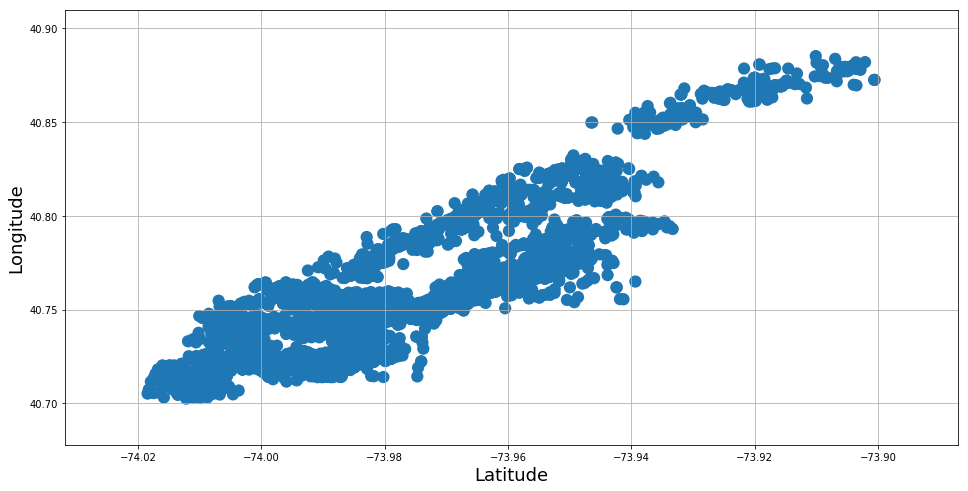

In [37]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(manhattan_onehot['Venue Longitude'], manhattan_onehot['Venue Latitude'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.grid()
plt.show()

### Run k means clustering to cluster the data into 5 clusters

In [38]:
kmeans_1 = KMeans(n_clusters=5)
# Using fit_predict to cluster the dataset
X = manhattan_onehot[['Venue Longitude','Venue Latitude']].values
predictions = kmeans_1.fit_predict(X)

In [39]:
clustered = pd.concat([manhattan_onehot.reset_index(), 
                       pd.DataFrame({'Cluster':predictions})], 
                      axis=1)

In [40]:
clustered.drop('index', axis=1, inplace=True)

In [41]:
conditions = [
    clustered['Cluster'] == 0, 
    clustered['Cluster'] == 1,
    clustered['Cluster'] == 2,
    clustered['Cluster'] == 3,
    clustered['Cluster'] == 4,]

In [42]:
clustered.sort_values(by=['Cluster']).head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Pizza Place,Diner,Coffee Shop,Mexican Restaurant,Donut Shop,Caribbean Restaurant,Café,Sandwich Place,Spanish Restaurant,Seafood Restaurant,Thai Restaurant,Cuban Restaurant,American Restaurant,Ice Cream Shop,Wine Shop,Steakhouse,Breakfast Spot,Latin American Restaurant,Chinese Restaurant,Greek Restaurant,Cocktail Bar,New American Restaurant,Asian Restaurant,Malay Restaurant,Snack Place,Vietnamese Restaurant,Austrian Restaurant,Dumpling Restaurant,Shanghai Restaurant,Dessert Shop,Cantonese Restaurant,Australian Restaurant,Pie Shop,Empanada Restaurant,Bagel Shop,Hotpot Restaurant,Noodle House,Food Court,French Restaurant,Restaurant,Italian Restaurant,Burger Joint,Ramen Restaurant,Tapas Restaurant,Frozen Yogurt Shop,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Arepa Restaurant,Bistro,Veterinarian,Venezuelan Restaurant,Mediterranean Restaurant,Sushi Restaurant,Japanese Restaurant,Food Truck,Ethiopian Restaurant,Southern / Soul Food Restaurant,Taco Place,African Restaurant,Food & Drink Shop,BBQ Joint,Japanese Curry Restaurant,Fried Chicken Joint,Falafel Restaurant,Cafeteria,Comfort Food Restaurant,Moroccan Restaurant,Hawaiian Restaurant,Burrito Place,Salad Place,Turkish Restaurant,Vegetarian / Vegan Restaurant,Hot Dog Joint,German Restaurant,Peruvian Restaurant,Health Food Store,Czech Restaurant,English Restaurant,Cambodian Restaurant,Persian Restaurant,Israeli Restaurant,Caucasian Restaurant,Szechuan Restaurant,Jewish Restaurant,Korean Restaurant,Smoothie Shop,Udon Restaurant,Lebanese Restaurant,Soup Place,Scandinavian Restaurant,Swiss Restaurant,Ukrainian Restaurant,Filipino Restaurant,Argentinian Restaurant,Eastern European Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Brazilian Restaurant,Wings Joint,Russian Restaurant,Halal Restaurant,Kosher Restaurant,Cluster
608,Central Harlem,40.815976,-73.943211,FIGS BARBERSHOP,40.816376,-73.946645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
503,Manhattanville,40.816934,-73.957385,Levels Barbershop,40.812058,-73.955157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
504,Manhattanville,40.816934,-73.957385,The World Famous Cotton Club,40.817587,-73.960274,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
505,Manhattanville,40.816934,-73.957385,Bettolona,40.814084,-73.959574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
506,Manhattanville,40.816934,-73.957385,The Craftsman,40.814612,-73.959148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Visualizing the clusters

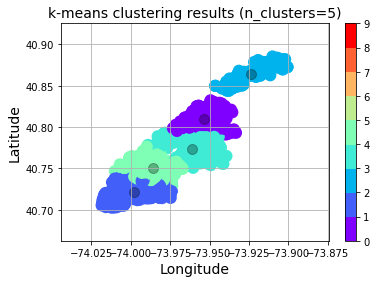

In [70]:
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Venue Longitude'], clustered['Venue Latitude'], c=clustered['Cluster'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,9,10))
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('k-means clustering results (n_clusters=5)', fontsize=14)
plt.grid()
plt.show()

### Finding out the cluster with the highest number of food places

In [51]:
most_food_places = clustered['Cluster'].value_counts()

most_food_places

1    1324
4    1003
3     816
0     557
2     284
Name: Cluster, dtype: int64

### Getting the centers of each cluster

In [58]:
cluster_centers = kmeans_1.cluster_centers_
cluster_centers

array([[-73.95353517,  40.810002  ],
       [-73.9977846 ,  40.72165408],
       [-73.92364094,  40.86375693],
       [-73.96133373,  40.77392878],
       [-73.98617698,  40.75009156]])

### Creating a table summarizing the clusters along with the latitude and longitude of the centers of the clusters

In [66]:
c = {'Cluster Number': [1, 4, 3, 0, 2], 'Number Of Food Places In Cluster':[1324, 1003, 816, 557, 284], 'Cluster Center Longitude': [-73.95353517,-73.9977846,-73.92364094,-73.96133373,-73.98617698], 'Cluster Center Latitude': [40.810002,40.72165408,40.86375693,40.77392878, 40.75009156 ]}
                                
clusdata = pd.DataFrame(data=c)
                                
clusdata

,Cluster Number,Number Of Food Places In Cluster,Cluster Center Longitude,Cluster Center Latitude
0,1,1324,-73.953535,40.810002
1,4,1003,-73.997785,40.721654
2,3,816,-73.923641,40.863757
3,0,557,-73.961334,40.773929
4,2,284,-73.986177,40.750092


### Visualizing the center of Cluster 1

In [68]:
latitude = 40.810002
longitude = -73.953535

venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

folium.features.CircleMarker(
    [latitude, longitude],
    radius=5,
    color='red',
    popup='Cluster 1 Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

venues_map

### Results: The best cluster is cluster 1 with 1324 food places in the cluster. We recommend the owner to set up office near the center of cluster 1 to get the best location in town based on the number of food places around the area.